In [250]:
library(tidyverse)
library(modelr)
options(na.action = na.warn)

# Lecture 18: Modeling
From now until the end of the course we will focus on statistical modeling ([Part IV](http://r4ds.had.co.nz/model-intro.html) of the book).

## What is a model
A statistical model is a mathematical formula that relates an outcome with one or more explanatory variables.
$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

### Model classes
The types of functions $f$ that we allow determine what is called the *model class*. For example, in STATS 250 you learned about linear regression, where $f$ is any function of the form 

$$f(x) = a_1 + a_2x $$

for some *parameters* $a_1$ and $a_2$. This defines a whole *family* of models: one for each choice of slope and intercept.

### Model fitting
The process of *fitting* a model refers to selecting the particular choice $\hat{a},\hat{b}$ from the family of models that we have chosen, in order to best fit the data. The fitted model is the member of the model family we have selected that is "closest" to the data. This *does not* mean that this is the "true" model! In most cases there is no "true" model. The goal of a model is not to uncover truth, but to discover a simple approximation that is still useful.

### Model selection
There is also the question of which family of models to use. In other words, which types of functions $f(x)$ to use. To use a fashionable example, we could have instead chosen our model family to be 

$$\{f: \text{$f$ is a neural network}\}.$$ 

The problem of choosing a model family is known as *model selection*. It is a much trickier problem than model fitting because there is no one correct answer: "all models are wrong"; the appropriate model family balances our needs for interpretability, predictiveness, etc.

### Example
We'll use the `modelr` package (again part of tidyverse) to learn about modeling.

In [251]:
library(modelr)

The `modelr` package comes with a simple bivariate dataset that we can model:

In [252]:
sim1 %>% print

# A tibble: 30 x 3
       x         y        resid
   <int>     <dbl>        <dbl>
 1     1  4.199913 -2.072442018
 2     1  7.510634  1.238279125
 3     1  2.125473 -4.146882207
 4     2  8.988857  0.664969362
 5     2 10.243105  1.919217378
 6     2 11.296823  2.972935148
 7     3  7.356365 -3.019056466
 8     3 10.505349  0.129928252
 9     3 10.511601  0.136179642
10     4 12.434589  0.007634878
# ... with 20 more rows


The first step is to explore the data using the techniques we have already learned:

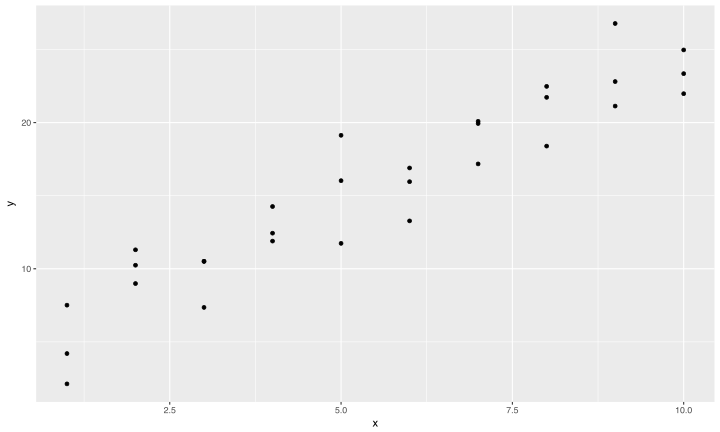

In [253]:
ggplot(sim1, aes(x, y)) + geom_point()

There is a strong linear relationship. We suspect that a good model might be the one we saw above: $y = a_1 + a_2x$. If we select a particular $a$ and $b$, this gives us a potential model for the data. We can plot this for various choices of $a_1$ and $a_2$ and see visually see how well it might fit:

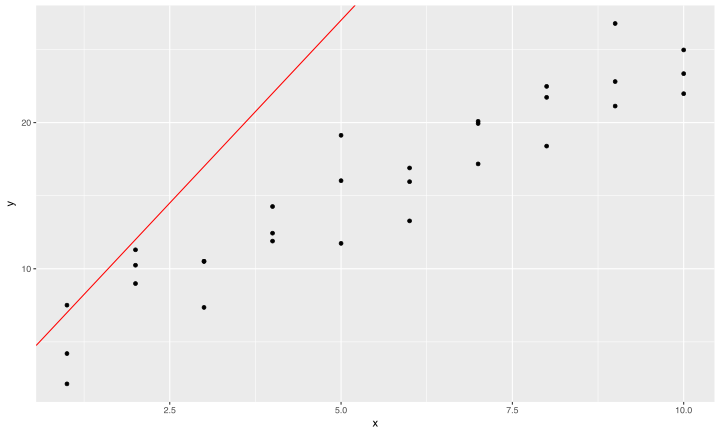

In [254]:
a1 = 2
a2 = 5
ggplot(sim1, aes(x, y)) + 
  geom_abline(aes(intercept = a1, slope = a2), color="red") +
  geom_point() 

The red line represents the value of $y$ that we would predict for each value of $x$. To measure how good our model fit is we can do the following: for each pair of data points $(x_i,y_i)$, measure the distance $|\hat{y}_i - y_i|$ between predicted and observed values of $y_i$. The value $\hat{y}_i - y_i$ is called the *residual*. It's the component of the data that isn't predicted by our model. Adding up the residuals gives us a measure of how good our model fits the data. If we predict the data perfectly ($\hat{y}_i = y_i$ for all $i$) then this would equal zero, so lower values are better. (Later you will learn that this is only true up to a point; it is generally not a good idea to fit the data perfectly.)

Let's define a model from this class:

In [255]:
model1 = function(a, x) {
    a[1] + a[2] * x 
}

Now we will write a function which takes a model and plots the residuals for each data point:

In [256]:
sim1_jitter = sim1 %>% mutate(x = x + rnorm(length(x)))
plot_diff = function(a) {
    sim1_jitter %>% mutate(y_hat = model1(a, x)) %>% 
        ggplot +
        geom_point(aes(x, y)) + 
        geom_point(aes(x, y_hat), shape=2) +
        geom_abline(aes(intercept = a[1], slope = a[2]), color="red") +
        geom_segment(aes(x = x, xend = x, y = y, yend = y_hat), color="blue") +
        xlim(c(0, 10)) + ylim(c(0, 30))
}

(I have jittered the data slightly to make the regression effect more apparent.)

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing missing values (geom_segment).”

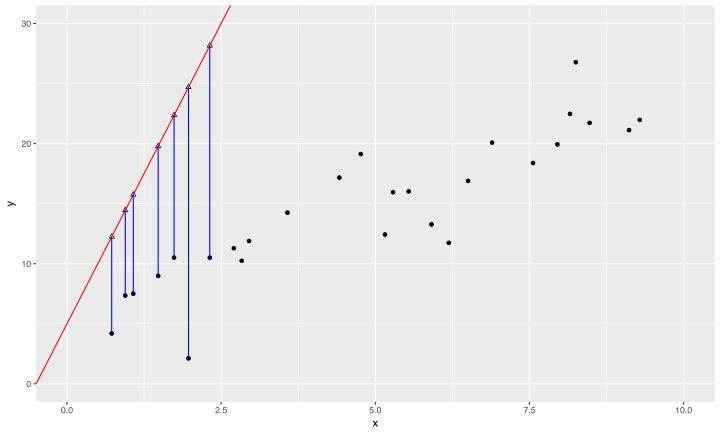

In [257]:
plot_diff(c(5, 10))

To measure how well our model peforms we define a function which adds up the square of the residuals:

In [258]:
measure_distance = function(a, data) {
  diff = data$y - model1(a, data$x)
  sqrt(mean(diff ^ 2))
}
measure_distance(c(7, 1.5), sim1)

[1] 2.665212

Now we want to figure out what is the best fitting model, i.e. the choice of $a$ that minimizes `measure_distance` as defined above. Let's first try simply generating a bunch of random models and seeing which one has the smallest `measure_distance`:

In [259]:
sim1_dist = function(a1, a2) {
  measure_distance(c(a1, a2), sim1)
}
a1 = runif(250, min = -20, max = 40)
a2 = runif(250, min = -5, max = 5)
dist = map2_dbl(a1, a2, sim1_dist)
head(dist)

[1] 38.67172 14.54581 16.45383 52.99849 38.55583 16.12051

Let's look at the ten best-fitting models (the ten indices $i$ for which `sim1_dist(a1[i], a2[i])` is smallest).

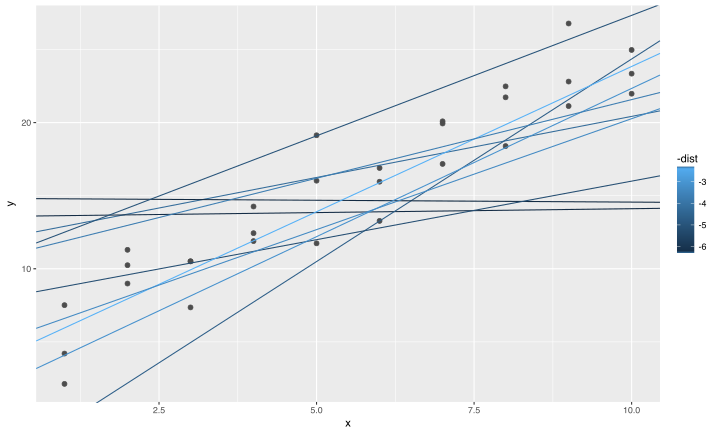

In [260]:
models = tibble(a1 = a1, a2 = a2, dist = dist)
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a1, slope = a2, colour = -dist), 
    data = filter(models, rank(dist) <= 10)
  )

We can also visualize the model fits by plotting `dist[i]` for each pair `c(a1[i], a2[i])`:

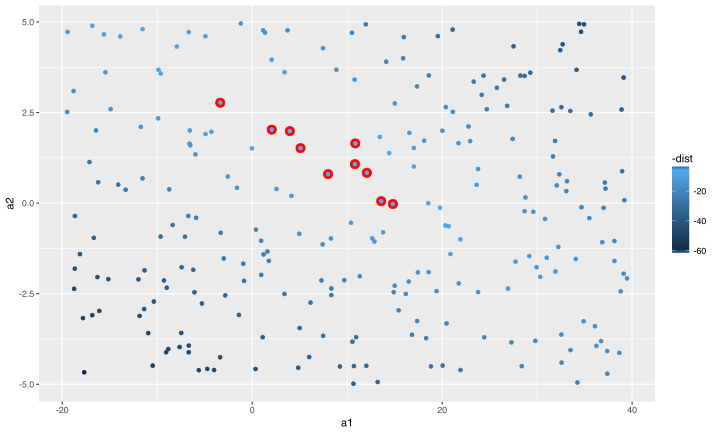

In [261]:
ggplot(models, aes(a1, a2)) +
  geom_point(data = filter(models, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))

Rather than exploring the models randomly let us systematically try all points on a grid of values:

In [262]:
grid <- expand.grid(
  a1 = seq(-5, 20, length = 25),
  a2 = seq(1, 3, length = 25)
  ) %>% 
  mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))

If we repeat the same plot, we see that the best fitting models are roughly centered around `a=c(4,2)`.

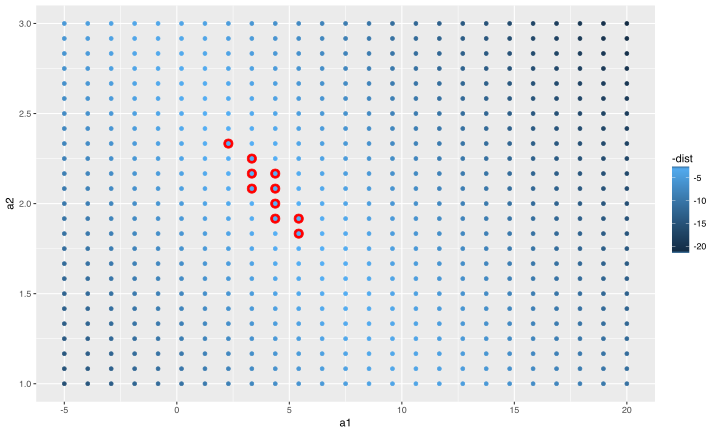

In [263]:
ggplot(grid, aes(a1, a2)) +
  geom_point(data = filter(grid, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))

If we plot these models they all fit the data pretty well:

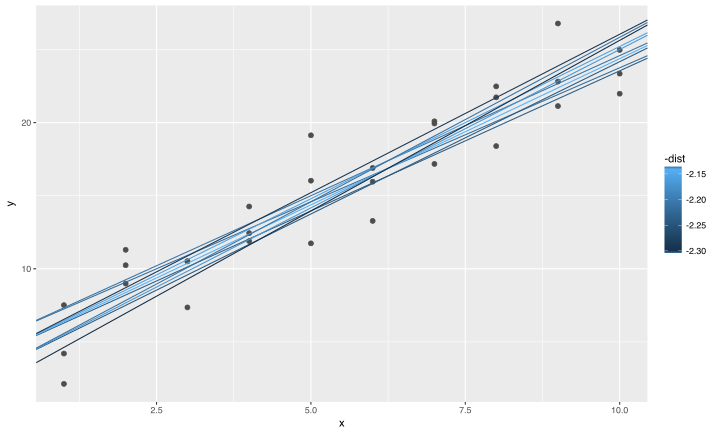

In [264]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(
    aes(intercept = a1, slope = a2, colour = -dist), 
    data = filter(grid, rank(dist) <= 10)
  )

To find the "best" model you could imagine taking a finer and finer grid of points:

In [265]:
grid <- expand.grid(
  a1 = seq(-5, 20, length = 50),
  a2 = seq(1, 3, length = 50)
  ) %>% 
  mutate(dist = purrr::map2_dbl(a1, a2, sim1_dist))

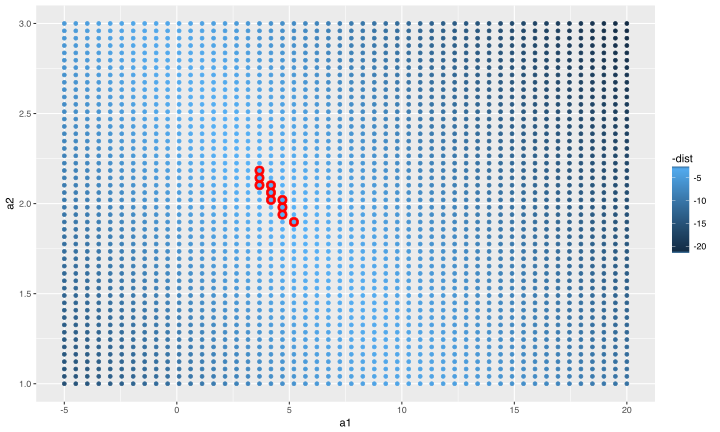

In [266]:
ggplot(grid, aes(a1, a2)) +
  geom_point(data = filter(grid, rank(dist) <= 10), size = 4, colour = "red") +
  geom_point(aes(colour = -dist))

But this "brute force" approach is wasteful. We can do much better by using an optimization algorithm to find the minimum for us.

### Optimization in R
Optimization means "find the minimum of a function". In R the command `optim` can be used to optimize a function:

In [267]:
optim(c(0), function(x) (x - 3)^2)$par

Warning message in optim(c(0), function(x) (x - 3)^2):
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”

[1] 2.9

We can use `optim` to find the values `a1` and `a2` that minimize `sim1_dist`: 

In [268]:
(res = optim(c(0, 0), function(a) sim1_dist(a[1], a[2])))
a_opt = res$par

$par
[1] 4.222248 2.051204

$value
[1] 2.128181

$counts
function gradient 
      77       NA 

$convergence
[1] 0

$message
NULL


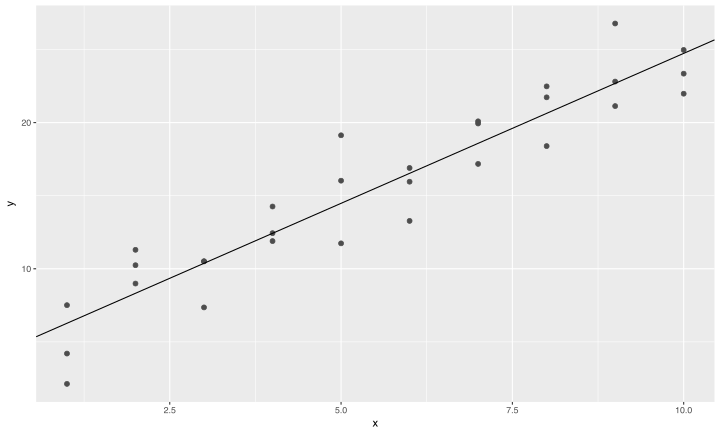

In [269]:
ggplot(sim1, aes(x, y)) + 
  geom_point(size = 2, colour = "grey30") + 
  geom_abline(aes(intercept = a_opt[1], slope = a_opt[2]))

### How `optim` works
Let's say I ask you to minimize the function:
$$f(x) = \frac{\log(1/x)}{x^3} - \sin(x)$$

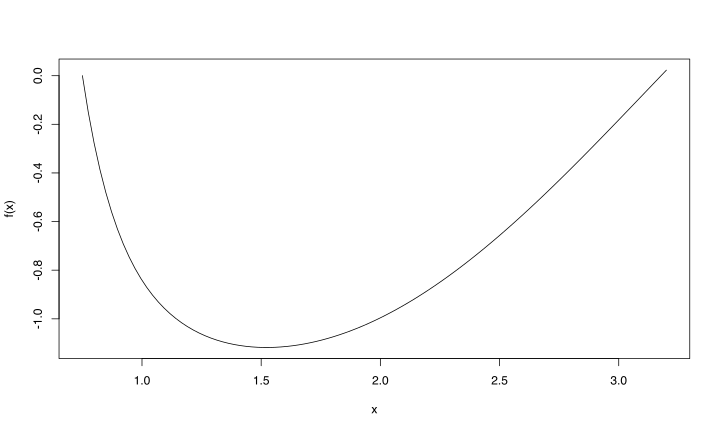

In [270]:
curve(f, from=3/4, to=3.2)

In [271]:
f = function(x) { -(log(x) / x^3 + sin(x)) }
df = function(x) { -(x^-4 + cos(x) - 3 * log(x) / x^4)}
d2f = function(x) { -(-7 / x^5 + 12 * log(x) / x^5 - sin(x)) }
xt = 2.5
plot.f = function(xt, xt1) {
        curve(f, from=3/4, to=3.2)
        curve(f(xt) + df(xt) * (x - xt) + .5 * d2f(xt) * (x - xt)^2, 
              from=3/4, to=3.2, col="blue", add=TRUE)
        points(c(xt,xt1), c(f(xt), f(xt1)))
        lines(c(xt,xt1), c(f(xt), f(xt1)), col="red")
}

The `optim` function works by approximating $f(x)$ by a parabola, and then moving to the minimum of that parabola. This is called the Newton-Raphson algorithm. (Actually `optim` uses more complicated algorithms, but the ideas are the same.)

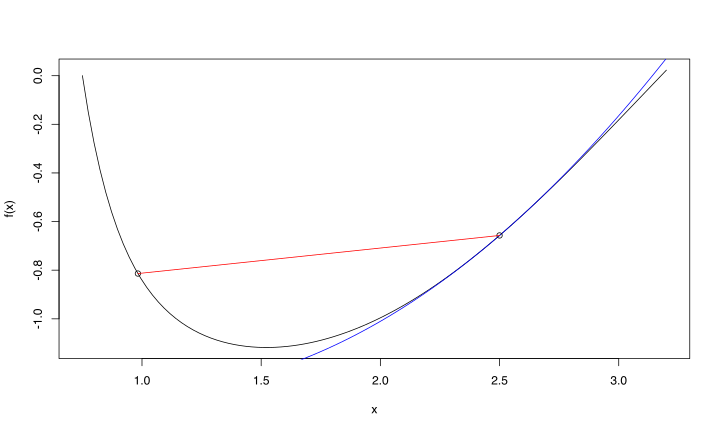

In [272]:
xt = 2.5
xt1 = xt - df(xt) / d2f(xt)
plot.f(xt, xt1)
xt = xt1

### The `lm` command
The simple linear model class we are considering is a special case of the larger family

$$y = a_0 + a_1 x_1 + \dots + a_p x_p.$$

R has a special commmand `lm` used to fit this type of model:

In [273]:
(sim1_mod = lm(y ~ x, data = sim1))


Call:
lm(formula = y ~ x, data = sim1)

Coefficients:
(Intercept)            x  
      4.221        2.052  


Note that these are the same parameter estimates that we got using `optim`:

In [274]:
a_opt

[1] 4.222248 2.051204

## Visualizing models
In this section we will learn some ways to visualize statistical models. One way is to look at the *predictions* made by the model over the observed range of values for our explanatory variable(s). The command `modelr::data_grid` will generate this for us:

In [275]:
(grid = sim1 %>% data_grid(x))

   x 
1   1
2   2
3   3
4   4
5   5
6   6
7   7
8   8
9   9
10 10

Next we will add the predictions for each $x$ value in `grid`:

In [276]:
(grid = grid %>% add_predictions(sim1_mod))

   x  pred     
1   1  6.272355
2   2  8.323888
3   3 10.375421
4   4 12.426954
5   5 14.478487
6   6 16.530020
7   7 18.581553
8   8 20.633087
9   9 22.684620
10 10 24.736153

Finally, we plot these predictions using `ggplot`:

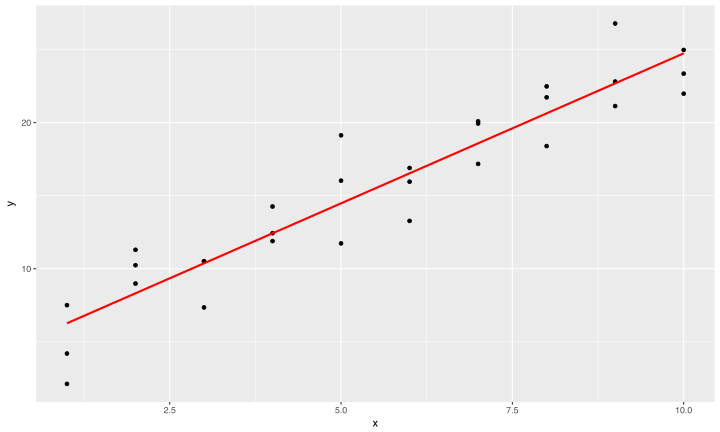

In [277]:
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size = 1)

What is the advantage of using `modelr` here versus just extracting the coefficients and doing it ourselves, as before? The `modelr` code works with any model. We could have used something more complicated for `sim1_mod`:

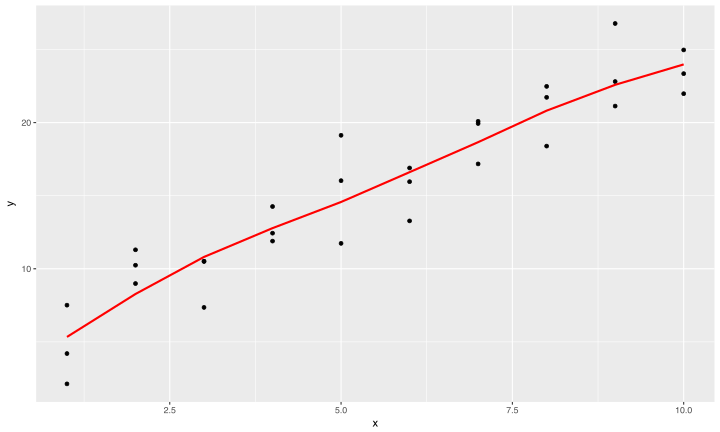

In [278]:
grid = grid %>% add_predictions(loess(y ~ x, sim1))
ggplot(sim1, aes(x)) +
  geom_point(aes(y = y)) +
  geom_line(aes(y = pred), data = grid, colour = "red", size = 1)

### Residuals
Each data point $y_i$ can be decomposed as 

$$y_i = \underbrace{\hat{y}_i}_\text{prediction} + \underbrace{\epsilon_i}_\text{residual}.$$

The prediction is the pattern in the data that the model has captured, and the residual is what is left over. To visualize residuals, we have a command called ... `add_residuals()`.

In [279]:
(sim1 = sim1 %>% add_residuals(sim1_mod))

   x  y         resid       
1   1  4.199913 -2.072442018
2   1  7.510634  1.238279125
3   1  2.125473 -4.146882207
4   2  8.988857  0.664969362
5   2 10.243105  1.919217378
6   2 11.296823  2.972935148
7   3  7.356365 -3.019056466
8   3 10.505349  0.129928252
9   3 10.511601  0.136179642
10  4 12.434589  0.007634878
11  4 11.892601 -0.534352991
12  4 14.257964  1.831009860
13  5 19.130050  4.651562487
14  5 11.738021 -2.740466108
15  5 16.024854  1.546366596
16  6 13.273977 -3.256043368
17  6 15.955975 -0.574045413
18  6 16.894796  0.364775796
19  7 20.085993  1.504439222
20  7 17.171850 -1.409703118
21  7 19.936309  1.354755377
22  8 21.725903  1.092815968
23  8 18.390913 -2.242173633
24  8 22.475553  1.842466099
25  9 26.777010  4.092390235
26  9 22.805110  0.120490168
27  9 21.128305 -1.556314330
28 10 24.968099  0.231946675
29 10 23.346422 -1.389730610
30 10 21.975201 -2.760952005

If you recall from STATS 250, the linear model assumes that the residuals $\epsilon_i$ are independent and normally distributed. By visualizing the residuals, we may judge whether this assumption holds or not:

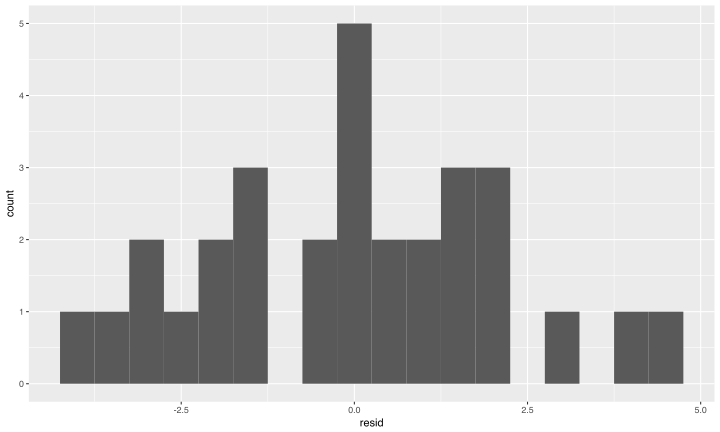

In [280]:
ggplot(sim1) + geom_histogram(aes(x=resid), binwidth=.5)

If the model has done a good job of capturing patterns in the data, then the residuals should look like random noise. (In other words, if the residuals contain obvious patterns, then there is more modeling work to be done!) You should confirm this by visualizing the residuals:

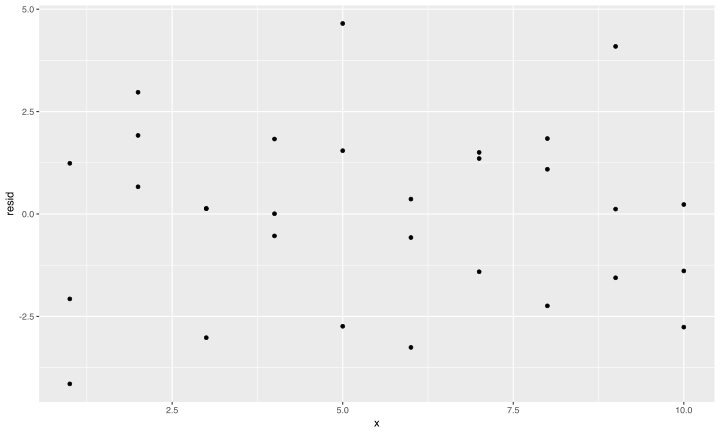

In [281]:
ggplot(sim1) + geom_point(aes(x=x, y=resid))

## Formulas
We have seen examples of formulas when working with the `facet_*()` commands, and also used them in place of anonymous functions with `map`. Formulas are most commonly used in model fitting commands like `lm`. 

We saw that the notation `y ~ x` cause R to fit the model 

$$y = a_1 + a_2 x.$$

The command `model_matrix` can show us exactly how formulas work on specific data examples:

In [282]:
df <- tribble(
  ~y, ~x1, ~x2,
  4, 2, 5,
  5, 1, 6
)
model_matrix(df, y ~ x1) %>% print

# A tibble: 2 x 2
  `(Intercept)`    x1
          <dbl> <dbl>
1             1     2
2             1     1


By default, R will add an intercept term. If you want to fit a model with no intercept, you should subtract 1 from the formula:

In [283]:
model_matrix(df, y ~ x1 - 1) %>% print

# A tibble: 2 x 1
     x1
  <dbl>
1     2
2     1


In [284]:
model_matrix(df, y ~ x1 + x2) %>% print

# A tibble: 2 x 3
  `(Intercept)`    x1    x2
          <dbl> <dbl> <dbl>
1             1     2     5
2             1     1     6


### Formulas with factors
The situation becomes more interesting when we consider models that contain factors:

In [285]:
df <- tribble(
  ~ sex, ~ response,
  "male", 1,
  "female", 2,
  "male", 1
)
model_matrix(df, response ~ sex)

  (Intercept) sexmale
1 1           1      
2 1           0      
3 1           1      

Our factor has two levels, yet only one column is generated in the model matrix. If we were to add a `sexfemale` column as well, the model matrix would look like:
```
  (Intercept) sexmale sexfemale
1 1           1       0        
2 1           0       1        
3 1           1       0  
```

Notice that `sexfemale = 1 - sexmale` always. If we were to try and fit this model we would have a problem:

$$
\begin{align*}
\text{response} &= a_1 + a_2 \text{sexmale} + a_3 \text{sexfemale} \\
                &= a_1 + a_2 \text{sexmale} + a_3 (1 - \text{female}) \\
                &= (a_1 + a_3) + (a_2 - a_3) \text{sexmale}.
\end{align*}
$$

Now multiple combinations of $a_1,a_2,a_3$ can lead to the same linear model. This will lead to errors if you try to fit this model, because the parameters are not unique.